In [45]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import model_from_json
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from model_select_func import save_model, load_model

In [2]:
np.random.seed(123) # set random seed for reproducability

In [3]:
tf.get_logger().setLevel('ERROR') # hide some warning messages

#### Load Test Datasets

In [4]:
original_split_data_path='../0. Project Data/Original Split Data'
reshaped_and_padded_data_path='../0. Project Data/Reshaped zero-padded and split data'

#### Image Parameters

In [5]:
#original data parameters
org_batch_size = 32
org_img_height = 180
org_img_width = 180
org_img_channels = 3

# padded image parameters
padded_batch_size = 32
padded_img_height = 256
padded_img_width = 256
padded_img_channels = 3

In [6]:
# tf.data dataset of original test data
org_test_ds = image_dataset_from_directory(
    original_split_data_path + '/test',
    image_size=(org_img_width, org_img_height),
    shuffle=False,
    seed=123)
# tf.data dataset of padded test data
padded_test_ds = image_dataset_from_directory(
    reshaped_and_padded_data_path + '/test',
    image_size=(padded_img_width, padded_img_height),
    batch_size=padded_batch_size)

Found 843 files belonging to 4 classes.
Found 843 files belonging to 4 classes.


In [ ]:
m1=load_model('Model 1-Original Data')

In [57]:
def record_results(model_name, model, dataset):
    '''
    Records metrics for given classifier
    ---Parameters---
    model_name (str) name of model
    model (keras model) fitted classifier
    dataset (tf.data.Dataset) test dataset
    ---Returns---
    list of metrics for classifier 
    '''
    y_pred_probas = model.predict(dataset)
    y_pred_labels = np.argmax(y_pred_probas, axis = 1)
    y_true_labels = []
    for images, labels in dataset:
        y_true_labels.extend(labels.numpy())
    f1 = f1_score(y_true_labels,y_pred_labels, average='weighted')
    precision= precision_score(y_true_labels, y_pred_labels, average='weighted')
    test_acc= accuracy_score(y_true_labels, y_pred_labels)
    recall=recall_score(y_true_labels, y_pred_labels, average='weighted')
    
    #roc=roc_auc_score(y_test, y_prob)
    return [model_name, f1, test_acc, precision, recall]
    #return [model_name, f1, test_acc, roc, precision, recall]

In [58]:
a=confusion_matrix(true_labels, y_pred_labels)

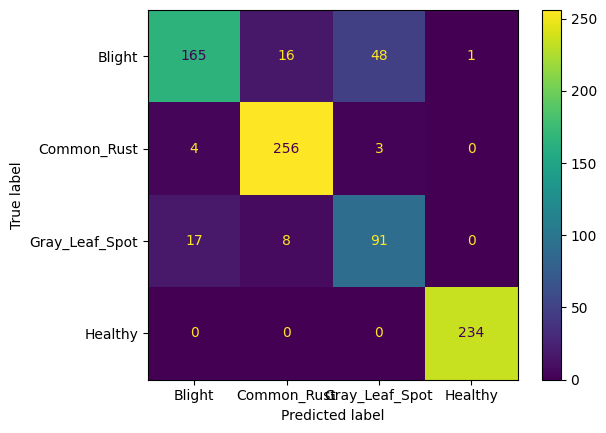

In [59]:
disp=ConfusionMatrixDisplay(confusion_matrix= a,display_labels=b )
disp.plot()
plt.show()

In [62]:
org_test_ds.class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [60]:
c= record_results('org', m1, org_test_ds)

27/27 [==============================] - 1s 26ms/step


In [61]:
c

['org',
 0.8846592094594734,
 0.8849347568208779,
 0.8918525319214972,
 0.8849347568208779]

In [31]:
f1_score(true_labels, y_pred_labels, average='micro')

0.8849347568208777

In [32]:
accuracy_score(true_labels, y_pred_labels)

0.8849347568208779

In [33]:
precision_score(true_labels, y_pred_labels, average='micro')

0.8849347568208779

In [34]:
recall_score(true_labels, y_pred_labels, average='micro')

0.8849347568208779

In [28]:
y_pred_labels

array([2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 2, 0, 0, 1, 0, 0, 0,
       0, 2, 1, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2,
       0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 3, 0, 0, 2, 0, 2, 0,
       0, 2, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1,

In [30]:
true_labels=np.array(true_labels)

In [63]:
type(m1)

keras.engine.functional.Functional

Loaded Model 1-Original Data from disk


In [15]:
type(y_pred)

numpy.ndarray

In [16]:
type(y_pred_labels)

numpy.ndarray

In [11]:
data={'Pred_Prob': list(y_pred), 'pred_label':y_pred_labels, 'true labels':true_labels}

In [12]:
a=pd.DataFrame(data)

In [13]:
a['same']=a.pred_label==a['true labels']

In [14]:
a['same'].mean()

0.8849347568208779

In [ ]:
'Model 1-Original Data'

In [ ]:
m1.evaluate(org_test_ds)

In [ ]:
for batch in org_test_ds:
    # Extract the images from the batch
    images = batch[0]  # Assuming the images are the first element of each batch

    # Iterate over the images in the batch
    for image in images:
        # Convert the image tensor to numpy array
        image_np = image.numpy()
        # Round due to bilinear interpolation
        image_np = np.round(image_np).astype(int)
        # Display the image using Matplotlib
        plt.imshow(image_np)
        #plt.axis('off')
        plt.show()

